In [80]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def isNaN(num):
    return num != num

In [3]:
df_regions = pd.read_csv('regions.csv')
df_weather = pd.read_csv('all_weather_by_hour_2023-2025_v1.csv', sep=",")
df_alarms = pd.read_csv('alarms-240222-010325.csv', sep=";")
df_isw_tfidf = pd.read_csv('bigram_tfidf_matrix.csv', sep=",")

In [4]:
df_pca = pd.read_csv('pca_tfidf_result.csv', sep=",")

## regions preparing

In [5]:
df_regions.head(5)

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5


In [6]:
# add Kyiv with id=26 to df_regions
kyiv_row = pd.DataFrame([{'region': 'Київ', 'center_city_ua': 'Київ', 'center_city_en': 'Kyiv', 'region_alt': 'Київ', 'region_id': 26}])
df_regions = pd.concat([df_regions, kyiv_row], ignore_index=True)

In [7]:
df_regions

,region,center_city_ua,center_city_en,region_alt,region_id
0,АР Крим,Сімферополь,Simferopol,Крим,1
1,Вінницька,Вінниця,Vinnytsia,Вінниччина,2
2,Волинська,Луцьк,Lutsk,Волинь,3
3,Дніпропетровська,Дніпро,Dnipro,Дніпропетровщина,4
4,Донецька,Донецьк,Donetsk,Донеччина,5
5,Житомирська,Житомир,Zhytomyr,Житомирщина,6
6,Закарпатська,Ужгород,Uzhgorod,Закарпаття,7
7,Запорізька,Запоріжжя,Zaporozhye,Запоріжжя,8
8,Івано-Франківська,Івано-Франківськ,Ivano-Frankivsk,Івано-Франківщина,9
9,Київська,Київ,Kyiv,Київщина,10


## alarms

In [8]:
df_alarms.head(5)

,id,region_id,region_city,all_region,start,end
0,52432,12,Львівська обл.,1,2022-02-24 07:43:17,2022-02-24 09:52:28
1,53292,23,Чернігівська обл.,1,2022-02-24 14:00:43,2022-02-24 17:11:43
2,52080,3,Вінницька обл.,1,2022-02-24 15:40:42,2022-02-24 16:10:42
3,52857,19,Харківська обл.,1,2022-02-24 20:11:47,2022-02-24 20:59:47
4,52700,18,Тернопільська обл.,1,2022-02-25 01:59:36,2022-02-25 09:00:19


In [9]:
# changing region_id in df_alarms according to region_id in df_regions
df_alarms['region_clean'] = df_alarms['region_city'].str.replace(' обл.', '', regex=False).str.strip()

region_mapping = dict(zip(df_regions['region'], df_regions['region_id']))

region_mapping_alt = dict(zip(df_regions['region_alt'], df_regions['region_id']))

full_mapping = {**region_mapping, **region_mapping_alt}

df_alarms['new_region_id'] = df_alarms['region_clean'].map(full_mapping)

In [10]:
df_alarms_unique = df_alarms.drop_duplicates(subset='new_region_id')
df_alarms_unique

,id,region_id,region_city,all_region,start,end,region_clean,new_region_id
0,52432,12,Львівська обл.,1,2022-02-24 07:43:17,2022-02-24 09:52:28,Львівська,13
1,53292,23,Чернігівська обл.,1,2022-02-24 14:00:43,2022-02-24 17:11:43,Чернігівська,25
2,52080,3,Вінницька обл.,1,2022-02-24 15:40:42,2022-02-24 16:10:42,Вінницька,2
3,52857,19,Харківська обл.,1,2022-02-24 20:11:47,2022-02-24 20:59:47,Харківська,20
4,52700,18,Тернопільська обл.,1,2022-02-25 01:59:36,2022-02-25 09:00:19,Тернопільська,19
9,72852,9,Київ,0,2022-02-25 07:19:04,2022-02-25 07:49:04,Київ,26
12,52555,16,Рівненська обл.,1,2022-02-25 11:50:53,2022-02-25 12:26:46,Рівненська,17
19,53091,22,Черкаська обл.,1,2022-02-25 18:54:07,2022-02-25 21:24:04,Черкаська,23
20,52554,14,Одеська обл.,1,2022-02-25 19:38:58,2022-02-25 20:30:58,Одеська,15
21,52427,8,Запорізька обл.,1,2022-02-25 20:13:06,2022-02-26 09:36:06,Запорізька,8


In [11]:
# we can see that there is no data for Luhansk (new_region_id=12)

In [12]:
# check for NaN values
df_alarms.isna().sum()

id               0
region_id        0
region_city      0
all_region       0
start            0
end              0
region_clean     0
new_region_id    0
dtype: int64

In [13]:
df_alarms["start_time"] = pd.to_datetime(df_alarms["start"])
df_alarms["end_time"] = pd.to_datetime(df_alarms["end"])

In [14]:
df_alarms["start_hour"] = df_alarms['start_time'].dt.floor('H')
df_alarms["end_hour"] = df_alarms['end_time'].dt.ceil('H')

In [15]:
df_alarms["day_date"] = df_alarms["start_time"].dt.date

df_alarms["start_hour_datetimeEpoch"] = df_alarms['start_hour'].apply(lambda x: int(x.strftime('%s'))  if not isNaN(x) else None)
df_alarms["end_hour_datetimeEpoch"] = df_alarms['end_hour'].apply(lambda x: int(x.strftime('%s'))  if not isNaN(x) else None)

In [16]:
df_alarms.sample(7)

,id,region_id,region_city,all_region,start,end,region_clean,new_region_id,start_time,end_time,start_hour,end_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch
1216,71251,24,Івано-Франківська обл.,1,2022-03-19 15:12:10,2022-03-19 16:31:50,Івано-Франківська,9,2022-03-19 15:12:10,2022-03-19 16:31:50,2022-03-19 15:00:00,2022-03-19 17:00:00,2022-03-19,1647694800,1647702000
28687,128508,4,Дніпропетровська обл.,1,2023-11-16 03:17:56,2023-11-16 05:34:36,Дніпропетровська,4,2023-11-16 03:17:56,2023-11-16 05:34:36,2023-11-16 03:00:00,2023-11-16 06:00:00,2023-11-16,1700096400,1700107200
54613,157217,6,Житомирська обл.,1,2025-02-07 23:38:44,2025-02-08 03:29:10,Житомирська,6,2025-02-07 23:38:44,2025-02-08 03:29:10,2025-02-07 23:00:00,2025-02-08 04:00:00,2025-02-07,1738962000,1738980000
35304,135982,7,Закарпатська обл.,1,2024-03-18 16:00:13,2024-03-18 16:12:53,Закарпатська,7,2024-03-18 16:00:13,2024-03-18 16:12:53,2024-03-18 16:00:00,2024-03-18 17:00:00,2024-03-18,1710770400,1710774000
14094,57019,4,Дніпропетровська обл.,1,2022-12-17 00:08:03,2022-12-17 00:42:20,Дніпропетровська,4,2022-12-17 00:08:03,2022-12-17 00:42:20,2022-12-17 00:00:00,2022-12-17 01:00:00,2022-12-17,1671228000,1671231600
20867,89741,20,Херсонська обл.,1,2023-06-14 20:11:33,2023-06-14 20:47:26,Херсонська,21,2023-06-14 20:11:33,2023-06-14 20:47:26,2023-06-14 20:00:00,2023-06-14 21:00:00,2023-06-14,1686762000,1686765600
14652,63107,10,Кіровоградська обл.,1,2022-12-31 23:11:13,2023-01-01 04:11:33,Кіровоградська,11,2022-12-31 23:11:13,2023-01-01 04:11:33,2022-12-31 23:00:00,2023-01-01 05:00:00,2022-12-31,1672520400,1672542000


In [17]:
df_alarms.shape

(55788, 15)

In [18]:
df_alarms.drop(['region_id','region_city', 'region_clean','start', 'end'], axis=1, inplace=True)

In [19]:
df_alarms['region_id'] = df_alarms['new_region_id']
df_alarms.drop(['new_region_id'], axis=1, inplace=True)

In [20]:
df_alarms.sample(7)

,id,all_region,start_time,end_time,start_hour,end_hour,day_date,start_hour_datetimeEpoch,end_hour_datetimeEpoch,region_id
41336,142856,1,2024-06-17 20:15:48,2024-06-17 21:12:33,2024-06-17 20:00:00,2024-06-17 22:00:00,2024-06-17,1718643600,1718650800,16
22263,96763,1,2023-07-16 18:23:28,2023-07-16 18:44:05,2023-07-16 18:00:00,2023-07-16 19:00:00,2023-07-16,1689519600,1689523200,20
36804,137615,1,2024-04-09 19:17:35,2024-04-09 20:07:52,2024-04-09 19:00:00,2024-04-09 21:00:00,2024-04-09,1712678400,1712685600,4
32711,133127,1,2024-02-02 17:33:00,2024-02-02 18:28:07,2024-02-02 17:00:00,2024-02-02 19:00:00,2024-02-02,1706886000,1706893200,14
7212,66312,1,2022-07-11 05:47:36,2022-07-11 06:02:13,2022-07-11 05:00:00,2022-07-11 07:00:00,2022-07-11,1657504800,1657512000,17
18486,76460,1,2023-04-17 23:18:06,2023-04-18 02:51:20,2023-04-17 23:00:00,2023-04-18 03:00:00,2023-04-17,1681761600,1681776000,18
30543,130739,1,2023-12-26 18:24:37,2023-12-26 18:55:00,2023-12-26 18:00:00,2023-12-26 19:00:00,2023-12-26,1703606400,1703610000,3


## weather preparing


In [21]:
df_weather.head(5)

,city_latitude,city_longitude,city_resolvedAddress,city_address,city_timezone,city_tzoffset,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,hour_uvindex,hour_conditions,hour_icon,hour_source,hour_stations
0,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1020.0,0.0,91.5,0.0,NaN,0.0,Overcast,snow,obs,remote
1,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.2,88.2,0.0,NaN,0.0,Partially cloudy,fog,obs,remote
2,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1022.0,10.0,100.0,NaN,NaN,NaN,Overcast,cloudy,obs,33177099999
3,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.1,92.0,0.0,NaN,0.0,Overcast,fog,obs,remote
4,50.7469,25.3263,"Луцьк, Луцький район, Україна","Lutsk,Ukraine",Europe/Kiev,2.0,2022-02-24,1645653600,4.9,0.7,...,1021.0,0.0,93.8,0.0,NaN,0.0,Overcast,cloudy,obs,remote


In [22]:
df_weather["day_datetime"] = pd.to_datetime(df_weather["day_datetime"])
df_weather.columns

Index(['city_latitude', 'city_longitude', 'city_resolvedAddress',
       'city_address', 'city_timezone', 'city_tzoffset', 'day_datetime',
       'day_datetimeEpoch', 'day_tempmax', 'day_tempmin', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 'day_feelslike', 'day_dew',
       'day_humidity', 'day_precip', 'day_precipprob', 'day_precipcover',
       'day_snow', 'day_snowdepth', 'day_windgust', 'day_windspeed',
       'day_winddir', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarradiation', 'day_solarenergy', 'day_uvindex', 'day_sunrise',
       'day_sunriseEpoch', 'day_sunset', 'day_sunsetEpoch', 'day_moonphase',
       'day_conditions', 'day_description', 'day_icon', 'day_source',
       'day_preciptype', 'day_stations', 'hour_datetime', 'hour_datetimeEpoch',
       'hour_temp', 'hour_feelslike', 'hour_humidity', 'hour_dew',
       'hour_precip', 'hour_precipprob', 'hour_snow', 'hour_snowdepth',
       'hour_preciptype', 'hour_windgust', 'hour_windsp

In [23]:
weather_exclude = ['city_latitude', 'city_longitude',
       'city_address', 'city_timezone', 
       'city_tzoffset', 'day_temp',
       'day_feelslikemax', 'day_feelslikemin', 
       'day_feelslike', 'day_precipprob', 
       'day_precipcover', 'day_snow', 
       'day_snowdepth', 'day_windgust',
       'day_winddir', 'day_solarradiation', 
       'day_uvindex', 'day_sunrise',
       'day_sunriseEpoch', 'day_sunset', 
       'day_sunsetEpoch', 'day_conditions', 
       'day_description', 'day_icon', 
       'day_source', 'day_preciptype', 
       'day_stations', 'hour_feelslike',
       'hour_precipprob','hour_preciptype',
       'hour_uvindex', 'hour_conditions', 
       'hour_icon', 'hour_source', 
       'hour_stations']

In [24]:
df_weather.drop(weather_exclude, axis=1, errors = 'ignore', inplace=True)

In [25]:
df_weather.sample(7)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,...,hour_snow,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy
80338,"Хмельницька область, Україна",2022-04-02,1648846800,10.0,2.2,4.2,86.0,0.100,25.2,996.0,...,0.0,0.0,37.4,18.4,303.2,996.0,24.1,100.0,47.0,0.2
486192,"Рівне, Україна",2023-11-26,1700949600,-0.3,-4.2,-4.1,82.9,0.198,25.9,1001.2,...,0.0,2.0,20.5,9.4,277.3,1001.0,NaN,99.8,0.0,0.0
521101,"Черкаси, Україна",2023-08-30,1693342800,31.0,20.4,17.6,63.2,0.000,20.2,1010.0,...,0.0,0.0,39.2,17.6,131.2,1010.0,NaN,13.0,691.1,2.5
530175,"Черкаси, Україна",2024-09-11,1726002000,27.4,14.9,15.6,72.6,0.100,10.8,1009.2,...,0.0,0.0,23.4,10.1,121.5,1008.0,NaN,42.6,331.0,1.2
160405,"Черкаси, Україна",2022-04-28,1651093200,16.1,7.2,4.4,61.9,0.400,7.2,1023.0,...,0.0,0.0,11.9,6.1,56.7,1023.0,24.1,99.7,637.0,2.3
577417,"Львів, Україна",2023-10-03,1696280400,22.1,7.2,10.0,74.7,0.000,18.7,1021.7,...,0.0,0.0,16.2,11.5,182.8,1025.0,NaN,63.4,0.0,0.0
323277,"Кропивницький, Україна",2024-04-24,1713906000,21.1,10.0,10.0,76.6,2.000,43.2,1008.3,...,0.0,0.0,24.1,10.1,213.1,1004.0,NaN,56.7,0.0,0.0


In [26]:
city_to_region_id = dict(zip(df_regions['center_city_ua'], df_regions['region_id']))

df_weather['city_clean'] = df_weather['city_resolvedAddress'].str.split(',').str[0].str.strip()
df_weather['city_clean'] = df_weather['city_clean'].replace('Хмельницька область', 'Хмельницький')
df_weather['region_id'] = df_weather['city_clean'].map(city_to_region_id)

In [27]:
df_weather.sample(7)

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,...,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,city_clean,region_id
129201,"Тернопіль, Україна",2022-05-22,1653166800,14.9,9.2,5.5,63.7,0.0,36.0,1009.9,...,52.2,27.4,302.5,1010.0,18.2,99.3,331.0,1.2,Тернопіль,19
292426,"Дніпро, Україна",2025-01-06,1736114400,3.3,-6.2,-3.1,88.1,3.0,25.2,1020.7,...,34.6,18.7,151.8,1022.0,NaN,99.4,60.3,0.2,Дніпро,4
332056,"Хмельницька область, Україна",2023-03-16,1678917600,3.6,0.1,-0.8,83.0,0.9,32.4,1016.4,...,49.3,24.5,352.8,1018.0,NaN,94.2,154.9,0.6,Хмельницький,22
497583,"Івано-Франківськ, Україна",2023-02-02,1675288800,4.8,0.1,-1.2,76.7,0.5,36.0,1009.5,...,41.8,18.0,273.9,1009.0,NaN,100.0,163.0,0.6,Івано-Франківськ,9
604020,"Полтава, Україна",2024-09-04,1725397200,27.9,18.2,4.7,31.3,0.0,25.2,1017.5,...,41.0,16.9,63.0,1018.0,NaN,89.5,422.4,1.5,Полтава,16
477774,"Житомир, Україна",2025-01-19,1737237600,5.1,-0.5,-0.5,82.3,0.0,21.6,1025.3,...,34.9,20.2,321.4,1025.0,NaN,40.5,0.0,0.0,Житомир,6
121773,"Житомир, Україна",2022-06-12,1654981200,27.6,16.7,15.0,64.8,0.0,17.6,1014.6,...,14.0,6.5,316.1,1015.0,24.1,51.6,0.0,NaN,Житомир,6


In [28]:
df_weather_unique = df_weather.drop_duplicates(subset='region_id')
df_weather_unique

,city_resolvedAddress,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,...,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,city_clean,region_id
0,"Луцьк, Луцький район, Україна",2022-02-24,1645653600,4.9,0.7,0.0,83.7,0.118,15.5,1022.3,...,31.3,15.5,275.6,1020.0,0.0,91.5,0.0,NaN,Луцьк,3
7944,"Кропивницький, Україна",2022-02-24,1645653600,6.2,-1.3,-1.2,78.9,0.000,10.8,1023.1,...,4.3,2.9,183.0,1021.0,24.1,56.2,0.0,NaN,Кропивницький,11
15888,"Дніпро, Україна",2022-02-24,1645653600,8.0,-2.0,-2.2,70.6,0.000,21.6,1021.9,...,9.7,10.8,4.0,1019.0,10.0,14.1,0.0,NaN,Дніпро,4
23832,"Київ, Україна",2022-02-24,1645653600,5.3,1.9,1.2,88.9,0.100,14.2,1021.9,...,28.8,7.4,217.0,1017.9,9.9,99.3,0.0,NaN,Київ,26
31776,"Херсон, Україна",2022-02-24,1645653600,9.8,0.0,-1.0,65.8,0.000,18.4,1021.5,...,11.2,7.6,29.4,1020.0,24.1,100.0,0.0,NaN,Херсон,21
39720,"Чернівці, Україна",2022-02-24,1645653600,6.5,-0.2,-0.8,74.9,0.008,17.9,1024.3,...,28.8,14.4,297.0,1023.3,10.0,30.0,0.0,NaN,Чернівці,24
47664,"Чернігів, Україна",2022-02-24,1645653600,5.2,0.3,-0.1,83.8,0.300,7.2,1022.8,...,12.6,7.2,181.5,1019.0,24.1,98.5,0.0,NaN,Чернігів,25
55608,"Одеса, Україна",2022-02-24,1645653600,9.0,1.0,0.8,74.0,0.000,21.6,1021.6,...,5.8,0.0,0.0,1019.0,10.0,93.7,0.0,NaN,Одеса,15
63552,"Миколаїв, Україна",2022-02-24,1645653600,8.8,0.0,-0.9,68.3,0.000,14.4,1021.8,...,6.8,3.2,129.8,1020.0,24.1,73.9,0.0,NaN,Миколаїв,14
71496,"Харків, Україна",2022-02-24,1645653600,5.0,-4.0,-4.7,70.0,0.000,18.0,1022.6,...,4.3,3.6,9.0,1019.0,6.0,1.5,0.0,NaN,Харків,20


In [29]:
# no Crimea and Luhansk

In [30]:
df_weather.drop(['city_resolvedAddress', 'city_clean'], axis=1, inplace=True)

In [31]:
nan_counts = df_weather.isna().sum()
print(nan_counts[nan_counts > 0].sort_values(ascending=False))

hour_visibility        276458
hour_solarenergy        87262
day_visibility          55352
hour_solarradiation      4336
day_solarenergy           552
hour_precip               102
dtype: int64


In [32]:
columns_to_check = [
    'hour_visibility',
    'hour_solarenergy', 
    'day_visibility', 
    'hour_solarradiation', 
    'day_solarenergy',
    'hour_precip',
    'hour_precip'
]

def fill_daily(group):
    for col in columns_to_check:
        if group[col].dtype in ['float64', 'int64']:
            mean_value = group[col].mean()
            group[col] = group[col].fillna(mean_value)
    return group

df_weather_cleaned = df_weather.groupby('day_datetime').apply(fill_daily)

for col in columns_to_check:
    if df_weather_cleaned[col].isna().any():
        df_weather_cleaned[col] = df_weather_cleaned[col].fillna(df_weather_cleaned[col].mean())

In [33]:
nan_counts = df_weather_cleaned.isna().sum()
print(nan_counts[nan_counts > 0].sort_values(ascending=False))

Series([], dtype: int64)


In [34]:
df_weather = df_weather_cleaned

In [35]:
df_weather_unique = df_weather.drop_duplicates(subset='region_id')
df_weather_unique

day_datetime  day_datetimeEpoch  day_tempmax  day_tempmin  \
day_datetime                                                                    
2022-02-24   0        2022-02-24         1645653600          4.9          0.7   
             7944     2022-02-24         1645653600          6.2         -1.3   
             15888    2022-02-24         1645653600          8.0         -2.0   
             23832    2022-02-24         1645653600          5.3          1.9   
             31776    2022-02-24         1645653600          9.8          0.0   
             39720    2022-02-24         1645653600          6.5         -0.2   
             47664    2022-02-24         1645653600          5.2          0.3   
             55608    2022-02-24         1645653600          9.0          1.0   
             63552    2022-02-24         1645653600          8.8          0.0   
             71496    2022-02-24         1645653600          5.0         -4.0   
             79440    2022-02-24         1645653600          4.7          0.2   
             87384    2022-02-24         1645653600          5.6          1.9   
             95328    2022-02-24         1645653600          6.7         -2.4   
             103272   2022-02-24         1645653600          8.0         -2.0   
             111216   2022-02-24         1645653600          4.7          0.8   
             119160   2022-02-24         1645653600          5.5          1.5   
             127104   2022-02-24         1645653600          3.8         -0.2   
             135048   2022-02-24         1645653600          5.7         -2.7   
             142992   2022-02-24         1645653600          6.0          0.0   
             150936   2022-02-24         1645653600          5.7          0.1   
             158880   2022-02-24         1645653600          4.9         -0.1   
             166824   2022-02-24         1645653600          5.3         -3.8   
             174768   2022-02-24         1645653600          5.0          0.7   

                     day_dew  day_humidity  day_precip  day_windspeed  \
day_datetime                                                            
2022-02-24   0           0.0          83.7       0.118           15.5   
             7944       -1.2          78.9       0.000           10.8   
             15888      -2.2          70.6       0.000           21.6   
             23832       1.2          88.9       0.100           14.2   
             31776      -1.0          65.8       0.000           18.4   
             39720      -0.8          74.9       0.008           17.9   
             47664      -0.1          83.8       0.300            7.2   
             55608       0.8          74.0       0.000           21.6   
             63552      -0.9          68.3       0.000           14.4   
             71496      -4.7          70.0       0.000           18.0   
             79440      -0.4          83.0       0.500           14.4   
             87384       0.7          81.0       1.300           14.4   
             95328      -1.6          79.9       0.000           14.1   
             103272     -2.1          69.5       0.000           21.6   
             111216      0.3          85.6       0.214           14.3   
             119160      0.2          80.8       0.800           10.8   
             127104     -1.0          83.8       2.000           18.0   
             135048     -3.6          71.9       0.000           10.8   
             142992     -1.0          76.8       0.400           14.4   
             150936     -1.4          75.2       0.800           15.1   
             158880     -0.6          83.4       0.000            8.3   
             166824     -4.7          69.9       0.000            7.9   
             174768     -0.3          80.5       0.300           10.8   

                     day_pressure  day_cloudcover  ...  hour_snowdepth  \
day_datetime                                       ...                   
2022-02-24   0      

In [36]:
# as we have different id's for Kiyv and Kyiv region we need to copy data from Kyiv to Kyiv region
replacement = df_weather[df_weather['region_id'] == 26].copy()
replacement['region_id'] = 10

df_weather = df_weather[df_weather['region_id'] != 10]

df_weather = pd.concat([df_weather, replacement], ignore_index=True)

In [37]:
df_weather_unique = df_weather.drop_duplicates(subset='region_id')
df_weather_unique

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id
0,2022-02-24,1645653600,4.9,0.7,0.0,83.7,0.118,15.5,1022.3,72.3,...,0.2,31.3,15.5,275.6,1020.0,0.0,91.5,0.0,0.595973,3
24,2022-02-24,1645653600,6.2,-1.3,-1.2,78.9,0.000,10.8,1023.1,85.2,...,0.0,4.3,2.9,183.0,1021.0,24.1,56.2,0.0,0.595973,11
48,2022-02-24,1645653600,8.0,-2.0,-2.2,70.6,0.000,21.6,1021.9,53.6,...,0.0,9.7,10.8,4.0,1019.0,10.0,14.1,0.0,0.595973,4
72,2022-02-24,1645653600,5.3,1.9,1.2,88.9,0.100,14.2,1021.9,99.7,...,0.0,28.8,7.4,217.0,1017.9,9.9,99.3,0.0,0.595973,26
96,2022-02-24,1645653600,9.8,0.0,-1.0,65.8,0.000,18.4,1021.5,87.7,...,0.0,11.2,7.6,29.4,1020.0,24.1,100.0,0.0,0.595973,21
120,2022-02-24,1645653600,6.5,-0.2,-0.8,74.9,0.008,17.9,1024.3,61.9,...,0.0,28.8,14.4,297.0,1023.3,10.0,30.0,0.0,0.595973,24
144,2022-02-24,1645653600,5.2,0.3,-0.1,83.8,0.300,7.2,1022.8,95.9,...,0.0,12.6,7.2,181.5,1019.0,24.1,98.5,0.0,0.595973,25
168,2022-02-24,1645653600,9.0,1.0,0.8,74.0,0.000,21.6,1021.6,82.9,...,0.0,5.8,0.0,0.0,1019.0,10.0,93.7,0.0,0.595973,15
192,2022-02-24,1645653600,8.8,0.0,-0.9,68.3,0.000,14.4,1021.8,80.7,...,0.0,6.8,3.2,129.8,1020.0,24.1,73.9,0.0,0.595973,14
216,2022-02-24,1645653600,5.0,-4.0,-4.7,70.0,0.000,18.0,1022.6,11.0,...,0.1,4.3,3.6,9.0,1019.0,6.0,1.5,0.0,0.595973,20


### during data visualisation we found anomalies in data which we need to replace

In [38]:
df_weather['hour_precip'].describe()

count    634752.000000
mean          0.086673
std           2.103550
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         300.000000
Name: hour_precip, dtype: float64

In [39]:
#hour_precip anomalies max = 306
precip_threshold = 50
precip_mask = df_weather['hour_precip'] > precip_threshold
df_weather.loc[precip_mask, 'hour_precip'] = df_weather.loc[precip_mask, 'hour_precip'] / 1000

precip_mask = df_weather['day_precip'] > precip_threshold
df_weather.loc[precip_mask, 'day_precip'] = df_weather.loc[precip_mask, 'day_precip'] / 1000

In [40]:
df_weather['hour_precip'].describe()

count    634752.000000
mean          0.069673
std           0.767416
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          50.000000
Name: hour_precip, dtype: float64

In [41]:
# temperature anomalies
df_weather['hour_temp'].describe()

count    634752.000000
mean         10.707913
std           9.790099
min         -50.300000
25%           2.400000
50%          10.200000
75%          18.400000
max          60.400000
Name: hour_temp, dtype: float64

In [42]:
df_weather.loc[df_weather['hour_temp'] == df_weather['hour_temp'].max()]

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id
71518,2022-07-03,1656795600,60.4,15.5,10.3,49.4,0.0,13.0,1018.3,29.2,...,0.0,14.8,4.7,290.0,1017.0,2.0,40.0,9.0,0.0,8


In [43]:
# as this anomalie is only in one region in one hour we can just delete it
df_weather = df_weather[df_weather['hour_temp'] != 60.4]

In [44]:
df_weather['hour_temp'].describe()

count    634751.000000
mean         10.707835
std           9.789908
min         -50.300000
25%           2.400000
50%          10.200000
75%          18.400000
max          39.400000
Name: hour_temp, dtype: float64

In [45]:
df_weather.loc[df_weather['hour_temp'] == df_weather['hour_temp'].min()]

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id
128374,2022-10-14,1665694800,14.5,-50.3,3.3,66.2,0.0,10.1,1023.8,38.7,...,0.0,10.1,6.1,260.0,1024.0,2.0,40.0,0.0,0.93447,8


In [46]:
df_weather = df_weather[df_weather['hour_temp'] != -50.3]

In [47]:
df_weather['hour_temp'].describe()

count    634750.000000
mean         10.707931
std           9.789616
min         -22.500000
25%           2.400000
50%          10.200000
75%          18.400000
max          39.400000
Name: hour_temp, dtype: float64

In [48]:
df_weather.sample(10)

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id
501674,2024-08-20,1724101200,35.7,18.1,15.9,58.0,0.000,7.9,1012.5,20.5,...,0.0,8.3,4.3,193.0,1013.0,15.553143,25.3,0.0,0.0,2
173243,2023-01-03,1672696800,11.6,-1.8,2.8,84.4,0.000,14.4,1025.6,78.0,...,0.0,7.6,14.4,270.0,1025.5,10.000000,60.0,167.0,0.6,9
624321,2023-12-23,1703282400,1.4,-0.7,-2.0,85.0,0.800,21.2,987.8,71.9,...,0.9,31.0,16.2,242.3,987.0,12.407143,99.2,20.0,0.1,10
606133,2025-02-26,1740520800,3.6,-13.6,-11.4,60.5,0.000,13.3,1023.5,49.5,...,0.7,25.6,12.2,156.8,1023.0,11.338235,46.3,486.6,1.8,25
163717,2022-12-17,1671228000,11.3,4.6,7.4,93.4,3.600,19.8,1016.6,99.1,...,0.0,29.5,15.5,162.7,1016.0,24.100000,98.7,224.0,0.8,8
16331,2022-03-25,1648159200,10.7,-1.0,-3.5,57.4,0.000,13.0,1019.3,36.1,...,0.0,25.9,13.0,73.1,1020.0,24.100000,95.9,660.0,2.4,8
461336,2024-06-08,1717794000,26.9,17.2,15.9,73.1,8.800,16.2,1013.5,54.6,...,0.0,13.0,4.3,271.7,1014.0,16.761735,13.8,151.6,0.5,23
113394,2022-09-17,1663362000,15.0,11.4,11.2,88.0,0.500,14.4,1005.2,99.7,...,0.0,12.6,3.2,201.3,1004.0,24.100000,100.0,72.0,0.3,22
629177,2024-07-12,1720731600,34.7,21.8,19.3,60.2,0.500,8.6,1015.6,31.7,...,0.0,13.7,0.0,164.4,1013.4,20.000000,80.0,331.9,1.2,10
292670,2023-08-08,1691442000,27.9,17.2,14.5,60.9,0.012,14.4,1011.1,23.4,...,0.0,28.1,11.5,354.4,1012.0,16.392537,0.0,821.7,3.0,4


#### scaler

In [49]:
df_weather.columns

Index(['day_datetime', 'day_datetimeEpoch', 'day_tempmax', 'day_tempmin',
       'day_dew', 'day_humidity', 'day_precip', 'day_windspeed',
       'day_pressure', 'day_cloudcover', 'day_visibility', 'day_solarenergy',
       'day_moonphase', 'hour_datetime', 'hour_datetimeEpoch', 'hour_temp',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_snow',
       'hour_snowdepth', 'hour_windgust', 'hour_windspeed', 'hour_winddir',
       'hour_pressure', 'hour_visibility', 'hour_cloudcover',
       'hour_solarradiation', 'hour_solarenergy', 'region_id'],
      dtype='object')

In [50]:
scaler = MinMaxScaler()
columns_to_scale = [
       'day_tempmax', 'day_tempmin',
       'day_dew', 'day_humidity', 'day_precip', 'day_windspeed',
       'day_pressure', 'day_cloudcover', 'day_visibility', 'day_solarenergy',
       'day_moonphase', 'hour_temp',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_snow',
       'hour_snowdepth', 'hour_windgust', 'hour_windspeed', 'hour_winddir',
       'hour_pressure', 'hour_visibility', 'hour_cloudcover',
       'hour_solarradiation', 'hour_solarenergy'
]
scaled_values = scaler.fit_transform(df_weather[columns_to_scale])
df_weather[columns_to_scale] = scaled_values

In [51]:
df_weather.sample(10)

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_snowdepth,hour_windgust,hour_windspeed,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id
596384,2025-02-08,1738965600,0.171352,0.536774,0.255370,0.658409,0.000,0.210286,0.925150,0.310,...,0.010280,0.156726,0.232222,0.160833,0.935065,0.176345,0.613,0.069118,0.058824,5
313753,2023-09-15,1694725200,0.460509,0.855484,0.885442,0.856584,0.336,0.181714,0.528443,0.667,...,0.000000,0.051807,0.087778,0.604722,0.571429,0.182716,0.239,0.000000,0.000000,8
159224,2022-12-09,1670536800,0.200803,0.611613,0.474940,0.976532,0.004,0.120000,0.479042,0.993,...,0.048598,0.069221,0.055556,0.336111,0.532468,0.005333,1.000,0.000000,0.054730,22
420851,2024-03-27,1711490400,0.370817,0.683871,0.563246,0.651890,0.008,0.140571,0.491018,0.325,...,0.000000,0.130170,0.135556,0.816944,0.545455,0.182276,0.487,0.508298,0.500000,5
204681,2023-03-01,1677621600,0.226238,0.601290,0.420048,0.775750,0.000,0.218286,0.606287,0.683,...,0.033645,0.138006,0.200000,0.789167,0.636364,0.167882,0.932,0.119958,0.117647,23
135078,2022-10-26,1666731600,0.377510,0.796129,0.754177,0.902216,0.180,0.131429,0.467066,0.981,...,0.000000,0.092730,0.115556,0.482500,0.506494,0.032000,1.000,0.000000,0.130499,16
147021,2022-11-17,1668636000,0.340027,0.726452,0.656325,0.883963,0.172,0.226286,0.293413,0.909,...,0.000000,0.158468,0.212222,0.856389,0.337662,0.321333,0.917,0.000000,0.066459,15
393541,2024-02-06,1707170400,0.326640,0.741935,0.563246,0.599739,0.080,0.366857,0.381737,0.969,...,0.000000,0.282107,0.384444,0.763611,0.454545,0.202419,1.000,0.151155,0.147059,13
553044,2024-11-21,1732140000,0.224900,0.634839,0.470167,0.861799,0.226,0.218286,0.251497,0.789,...,0.063551,0.192860,0.240000,0.851944,0.298701,0.118630,1.000,0.125420,0.117647,2
324236,2023-10-04,1696366800,0.449799,0.704516,0.613365,0.568449,0.000,0.102857,0.615269,0.304,...,0.000000,0.050065,0.092222,0.556111,0.623377,0.187113,0.021,0.000000,0.000000,5


In [52]:
df_weather['hour_full'] = df_weather['day_datetime'].astype(str) + ' ' + df_weather['hour_datetime'].astype(str)

df_weather['hour'] = pd.to_datetime(df_weather['hour_full'], format='%Y-%m-%d %H:%M:%S').dt.floor('h')

## Merging weather + alarms

In [53]:
expanded_alarms = []

for _, row in df_alarms.iterrows():
    if pd.notnull(row['start_hour']) and pd.notnull(row['end_hour']):
        hours = pd.date_range(start=row['start_hour'], end=row['end_hour'], freq='H')
        for hour in hours:
            expanded_alarms.append({'region_id': row['region_id'], 'hour': hour})

df_alarm_hours = pd.DataFrame(expanded_alarms)
df_alarm_hours['was_alarm'] = 1

In [54]:
df_alarm_hours

,region_id,hour,was_alarm
0,13,2022-02-24 07:00:00,1
1,13,2022-02-24 08:00:00,1
2,13,2022-02-24 09:00:00,1
3,13,2022-02-24 10:00:00,1
4,25,2022-02-24 14:00:00,1
...,...,...,...
179403,6,2025-03-01 23:00:00,1
179404,6,2025-03-02 00:00:00,1
179405,6,2025-03-02 01:00:00,1
179406,6,2025-03-02 02:00:00,1


In [55]:
df_weather['hour'] = pd.to_datetime(df_weather['hour']).dt.strftime('%Y-%m-%d %H:%M:%S')
df_alarm_hours['hour'] = pd.to_datetime(df_alarm_hours['hour']).dt.strftime('%Y-%m-%d %H:%M:%S')

df_weather_with_alarm = pd.merge(
    df_weather,
    df_alarm_hours,
    how='left',
    on=['region_id', 'hour']
)

df_weather_with_alarm['was_alarm'] = df_weather_with_alarm['was_alarm'].fillna(0).astype(int)
df_weather_with_alarm

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_winddir,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id,hour_full,hour,was_alarm
0,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.765556,0.610390,0.000000,0.915,0.000000,0.175286,3,2022-02-24 00:00:00,2022-02-24 00:00:00,0
1,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.778611,0.623377,0.002667,0.882,0.000000,0.175286,3,2022-02-24 01:00:00,2022-02-24 01:00:00,0
2,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.861111,0.636364,0.133333,1.000,0.095973,0.175286,3,2022-02-24 02:00:00,2022-02-24 02:00:00,0
3,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.819722,0.623377,0.001333,0.920,0.000000,0.175286,3,2022-02-24 03:00:00,2022-02-24 03:00:00,0
4,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.849444,0.623377,0.000000,0.938,0.000000,0.175286,3,2022-02-24 04:00:00,2022-02-24 04:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656437,2025-03-01,1740780000,0.206158,0.634839,0.431981,0.777053,0.01400,0.148571,0.675150,0.995,...,0.504444,0.701299,0.113285,0.956,0.000000,0.000000,10,2025-03-01 19:00:00,2025-03-01 19:00:00,0
656438,2025-03-01,1740780000,0.206158,0.634839,0.431981,0.777053,0.01400,0.148571,0.675150,0.995,...,0.527500,0.701299,0.053333,1.000,0.000000,0.000000,10,2025-03-01 20:00:00,2025-03-01 20:00:00,0
656439,2025-03-01,1740780000,0.206158,0.634839,0.431981,0.777053,0.01400,0.148571,0.675150,0.995,...,0.550833,0.701299,0.113285,1.000,0.000000,0.000000,10,2025-03-01 21:00:00,2025-03-01 21:00:00,0
656440,2025-03-01,1740780000,0.206158,0.634839,0.431981,0.777053,0.01400,0.148571,0.675150,0.995,...,0.555278,0.701299,0.113285,0.976,0.000000,0.000000,10,2025-03-01 22:00:00,2025-03-01 22:00:00,1


## Feature Engineering: Percent of other regions with alarm

In [56]:
all_regions = df_weather_with_alarm['region_id'].unique()
total_regions = len(all_regions)

alarms = df_weather_with_alarm[df_weather_with_alarm['was_alarm'] == 1]
alarm_counts = alarms.groupby('hour')['region_id'].nunique().reset_index()
alarm_counts.columns = ['hour', 'alarm_regions_count']

df_weather_with_alarm = df_weather_with_alarm.merge(alarm_counts, on='hour', how='left')

df_weather_with_alarm['other_regions_with_alarm_percent'] = df_weather_with_alarm.apply(
    lambda row: ((row['alarm_regions_count'] - 1) / (total_regions - 1))
    if pd.notna(row['alarm_regions_count']) and row['was_alarm'] == 1 and total_regions > 1
    else 0,
    axis=1
)

df_weather_with_alarm.drop(columns=['alarm_regions_count'], inplace=True)

In [57]:
df_weather_with_alarm_unique = df_weather_with_alarm.drop_duplicates(subset='region_id')
df_weather_with_alarm_unique

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id,hour_full,hour,was_alarm,other_regions_with_alarm_percent
0,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.610390,0.000000,0.915,0.0,0.175286,3,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
24,2022-02-24,1645653600,0.274431,0.632258,0.465394,0.724902,0.00000,0.094857,0.621257,0.852,...,0.623377,0.321333,0.562,0.0,0.175286,11,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
48,2022-02-24,1645653600,0.298527,0.623226,0.441527,0.616688,0.00000,0.218286,0.603293,0.536,...,0.597403,0.133333,0.141,0.0,0.175286,4,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
72,2022-02-24,1645653600,0.262383,0.673548,0.522673,0.855280,0.00200,0.133714,0.603293,0.997,...,0.583117,0.132000,0.993,0.0,0.175286,26,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
96,2022-02-24,1645653600,0.322624,0.649032,0.470167,0.554107,0.00000,0.181714,0.597305,0.877,...,0.610390,0.321333,1.000,0.0,0.175286,21,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
120,2022-02-24,1645653600,0.278447,0.646452,0.474940,0.672751,0.00016,0.176000,0.639222,0.619,...,0.653247,0.133333,0.300,0.0,0.175286,24,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
144,2022-02-24,1645653600,0.261044,0.652903,0.491647,0.788787,0.00600,0.053714,0.616766,0.959,...,0.597403,0.321333,0.985,0.0,0.175286,25,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
168,2022-02-24,1645653600,0.311914,0.661935,0.513126,0.661017,0.00000,0.218286,0.598802,0.829,...,0.597403,0.133333,0.937,0.0,0.175286,15,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
192,2022-02-24,1645653600,0.309237,0.649032,0.472554,0.586701,0.00000,0.136000,0.601796,0.807,...,0.610390,0.321333,0.739,0.0,0.175286,14,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0
216,2022-02-24,1645653600,0.258367,0.597419,0.381862,0.608866,0.00000,0.177143,0.613772,0.110,...,0.597403,0.080000,0.015,0.0,0.175286,20,2022-02-24 00:00:00,2022-02-24 00:00:00,0,0.0


In [58]:
df_weather_with_alarm.drop(['hour', 'hour_full'], axis=1, inplace=True)

In [59]:
df_weather_with_alarm.shape

(656442, 32)

## Merging with isw (pca)

In [60]:
df_pca.head(5)

,date,PC1,PC2
0,05-04-2025,0.164521,-0.108821
1,04-04-2025,0.389580,-0.098341
2,03-04-2025,0.314317,-0.056887
3,02-04-2025,0.156906,-0.050380
4,01-04-2025,-0.175722,-0.320290


In [61]:
df_daily = df_weather_with_alarm.groupby('day_datetime').mean(numeric_only=True).reset_index()
df_daily_with_pca = pd.concat([df_daily.reset_index(drop=True), df_pca], axis=1)
merged_df = df_weather_with_alarm.merge(df_daily_with_pca[['day_datetime', 'PC1', 'PC2']], on='day_datetime',
                                           how='left')

In [62]:
merged_df.shape

(656442, 34)

In [63]:
merged_df.sample(10)

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id,was_alarm,other_regions_with_alarm_percent,PC1,PC2
304947,2023-08-16,1692133200,0.618474,0.869677,0.899761,0.513690,0.000,0.094857,0.609281,0.273,...,0.649351,0.209886,0.078,0.474475,0.470588,6,0,0.000000,-0.162430,0.061099
277699,2023-06-29,1687986000,0.479250,0.829677,0.792363,0.636245,0.006,0.226286,0.360778,0.711,...,0.441558,0.199729,0.317,0.186450,0.176471,16,1,0.173913,0.182086,0.185643
182916,2023-01-12,1673474400,0.269076,0.628387,0.503580,0.929596,0.000,0.136000,0.576347,0.690,...,0.597403,0.321333,0.807,0.255252,0.264706,13,0,0.000000,-0.026999,-0.046124
57124,2022-06-03,1654203600,0.508701,0.809032,0.744630,0.507171,0.000,0.136000,0.615269,0.572,...,0.675325,0.321333,0.824,0.517857,0.529412,9,0,0.000000,0.407997,-0.122499
580016,2024-12-05,1733349600,0.187416,0.627097,0.427208,0.840939,0.000,0.136000,0.712575,0.990,...,0.732468,0.133333,1.000,0.080252,0.088235,11,0,0.000000,-0.152217,-0.075976
626203,2025-02-24,1740348000,0.220884,0.456774,0.176611,0.499348,0.000,0.094857,0.718563,0.004,...,0.727273,0.162340,0.000,0.508508,0.500000,25,1,1.000000,-0.158613,-0.168417
430895,2024-03-22,1711058400,0.357430,0.615484,0.536993,0.732725,0.000,0.115429,0.552395,0.815,...,0.587013,0.133333,1.000,0.456513,0.470588,9,0,0.000000,-0.088938,0.358925
436438,2024-04-01,1711918800,0.448461,0.758710,0.720764,0.770535,0.000,0.156571,0.476048,0.649,...,0.506494,0.140455,0.921,0.094958,0.088235,15,0,0.000000,0.006055,0.386704
507755,2024-08-01,1722459600,0.587684,0.820645,0.789976,0.447197,0.000,0.156571,0.425150,0.417,...,0.441558,0.232106,0.098,0.200525,0.205882,23,0,0.000000,0.084677,0.303472
468850,2024-05-26,1716670800,0.535475,0.788387,0.579952,0.220339,0.000,0.136000,0.622754,0.346,...,0.662338,0.228072,0.728,0.252101,0.264706,17,0,0.000000,-0.205909,-0.148501


In [64]:
merged_df_unique = merged_df.drop_duplicates(subset='region_id')
merged_df_unique

,day_datetime,day_datetimeEpoch,day_tempmax,day_tempmin,day_dew,day_humidity,day_precip,day_windspeed,day_pressure,day_cloudcover,...,hour_pressure,hour_visibility,hour_cloudcover,hour_solarradiation,hour_solarenergy,region_id,was_alarm,other_regions_with_alarm_percent,PC1,PC2
0,2022-02-24,1645653600,0.257028,0.658065,0.494033,0.787484,0.00236,0.148571,0.609281,0.723,...,0.610390,0.000000,0.915,0.0,0.175286,3,0,0.0,0.164521,-0.108821
24,2022-02-24,1645653600,0.274431,0.632258,0.465394,0.724902,0.00000,0.094857,0.621257,0.852,...,0.623377,0.321333,0.562,0.0,0.175286,11,0,0.0,0.164521,-0.108821
48,2022-02-24,1645653600,0.298527,0.623226,0.441527,0.616688,0.00000,0.218286,0.603293,0.536,...,0.597403,0.133333,0.141,0.0,0.175286,4,0,0.0,0.164521,-0.108821
72,2022-02-24,1645653600,0.262383,0.673548,0.522673,0.855280,0.00200,0.133714,0.603293,0.997,...,0.583117,0.132000,0.993,0.0,0.175286,26,0,0.0,0.164521,-0.108821
96,2022-02-24,1645653600,0.322624,0.649032,0.470167,0.554107,0.00000,0.181714,0.597305,0.877,...,0.610390,0.321333,1.000,0.0,0.175286,21,0,0.0,0.164521,-0.108821
120,2022-02-24,1645653600,0.278447,0.646452,0.474940,0.672751,0.00016,0.176000,0.639222,0.619,...,0.653247,0.133333,0.300,0.0,0.175286,24,0,0.0,0.164521,-0.108821
144,2022-02-24,1645653600,0.261044,0.652903,0.491647,0.788787,0.00600,0.053714,0.616766,0.959,...,0.597403,0.321333,0.985,0.0,0.175286,25,0,0.0,0.164521,-0.108821
168,2022-02-24,1645653600,0.311914,0.661935,0.513126,0.661017,0.00000,0.218286,0.598802,0.829,...,0.597403,0.133333,0.937,0.0,0.175286,15,0,0.0,0.164521,-0.108821
192,2022-02-24,1645653600,0.309237,0.649032,0.472554,0.586701,0.00000,0.136000,0.601796,0.807,...,0.610390,0.321333,0.739,0.0,0.175286,14,0,0.0,0.164521,-0.108821
216,2022-02-24,1645653600,0.258367,0.597419,0.381862,0.608866,0.00000,0.177143,0.613772,0.110,...,0.597403,0.080000,0.015,0.0,0.175286,20,0,0.0,0.164521,-0.108821


In [74]:
merged_df.columns

Index(['day_tempmax', 'day_tempmin', 'day_dew', 'day_humidity', 'day_precip',
       'day_windspeed', 'day_pressure', 'day_cloudcover', 'day_visibility',
       'day_solarenergy', 'day_moonphase', 'hour_datetimeEpoch', 'hour_temp',
       'hour_humidity', 'hour_dew', 'hour_precip', 'hour_snow',
       'hour_snowdepth', 'hour_windgust', 'hour_windspeed', 'hour_winddir',
       'hour_pressure', 'hour_visibility', 'hour_cloudcover',
       'hour_solarradiation', 'hour_solarenergy', 'region_id', 'was_alarm',
       'other_regions_with_alarm_percent', 'PC1', 'PC2'],
      dtype='object')

## day_tempmax, day_cloudcover, hour_solarradiation

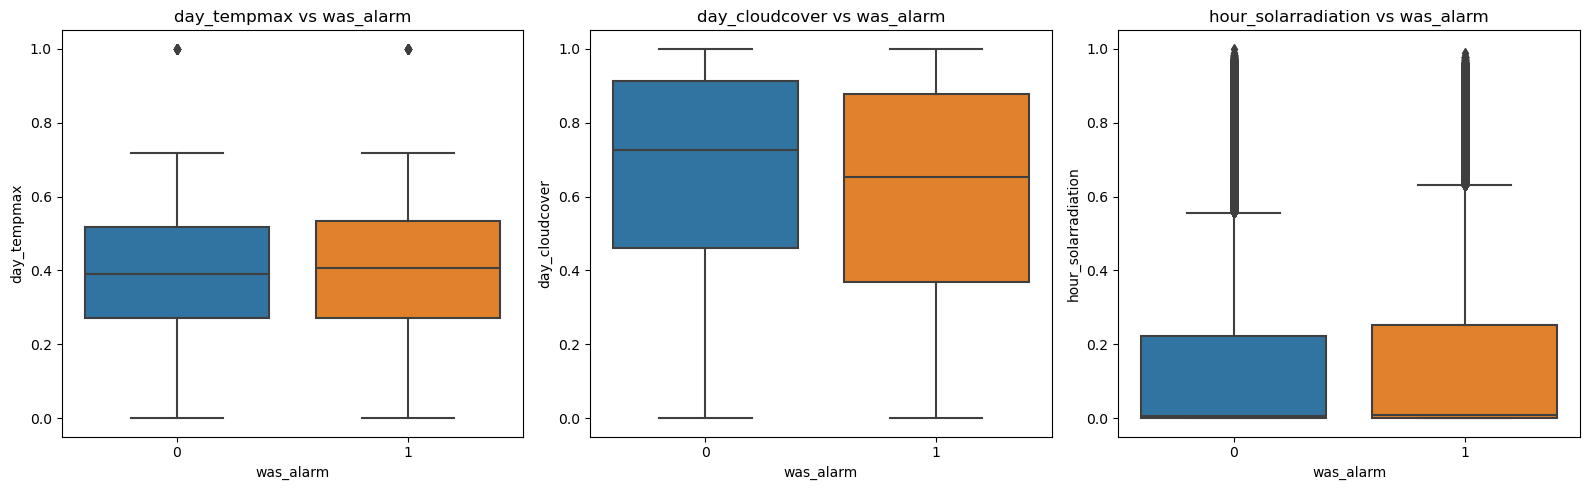

In [83]:
plt.figure(figsize=(16, 5))
features_boxplot = ['day_tempmax', 'day_cloudcover', 'hour_solarradiation']
for i, feature in enumerate(features_boxplot, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=merged_df, x='was_alarm', y=feature)
    plt.title(f'{feature} vs was_alarm')
plt.tight_layout()
plt.show()

## Гістограми розподілу PCA компонент (PC1, PC2)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


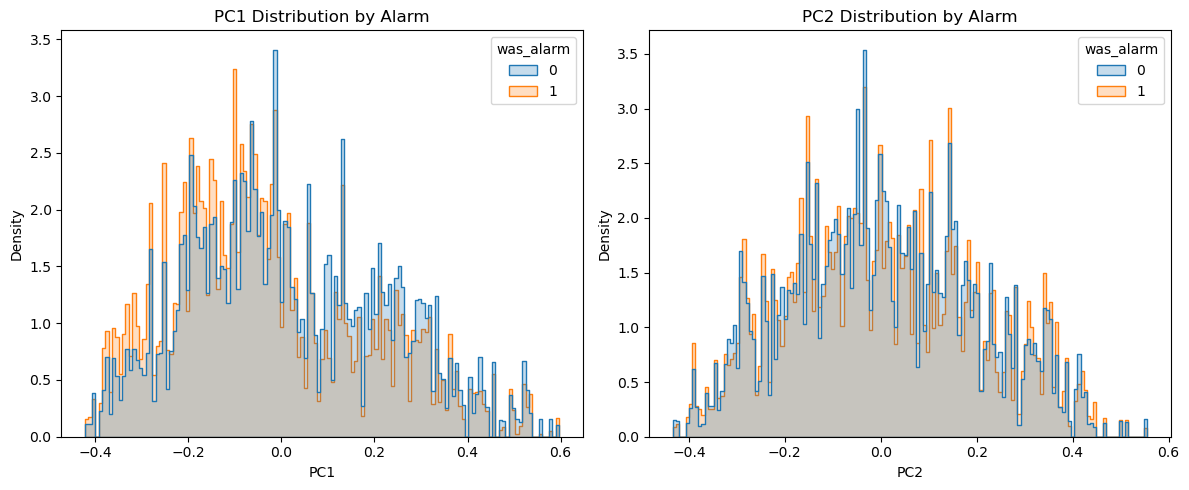

In [85]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=merged_df, x='PC1', hue='was_alarm', element='step', stat='density', common_norm=False)
plt.title('PC1 Distribution by Alarm')

plt.subplot(1, 2, 2)
sns.histplot(data=merged_df, x='PC2', hue='was_alarm', element='step', stat='density', common_norm=False)
plt.title('PC2 Distribution by Alarm')

plt.tight_layout()
plt.show()

## Scatter plot PC1 vs PC2

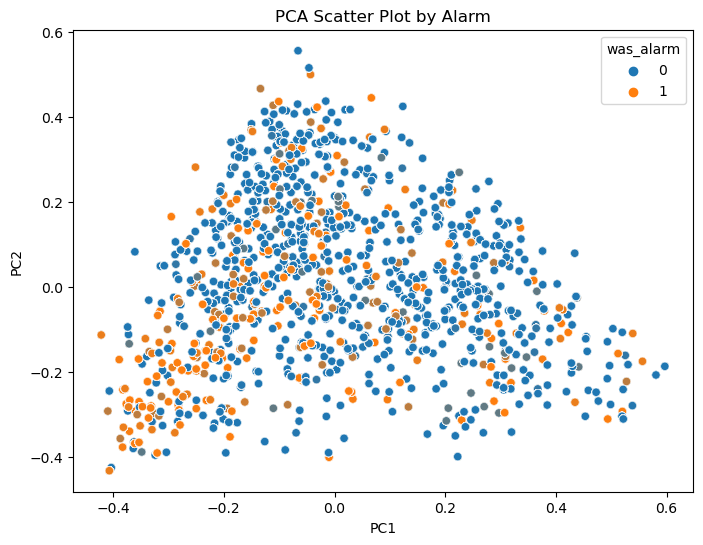

In [87]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='PC1', y='PC2', hue='was_alarm', alpha=0.7)
plt.title('PCA Scatter Plot by Alarm')
plt.show()

## Correlation matrix

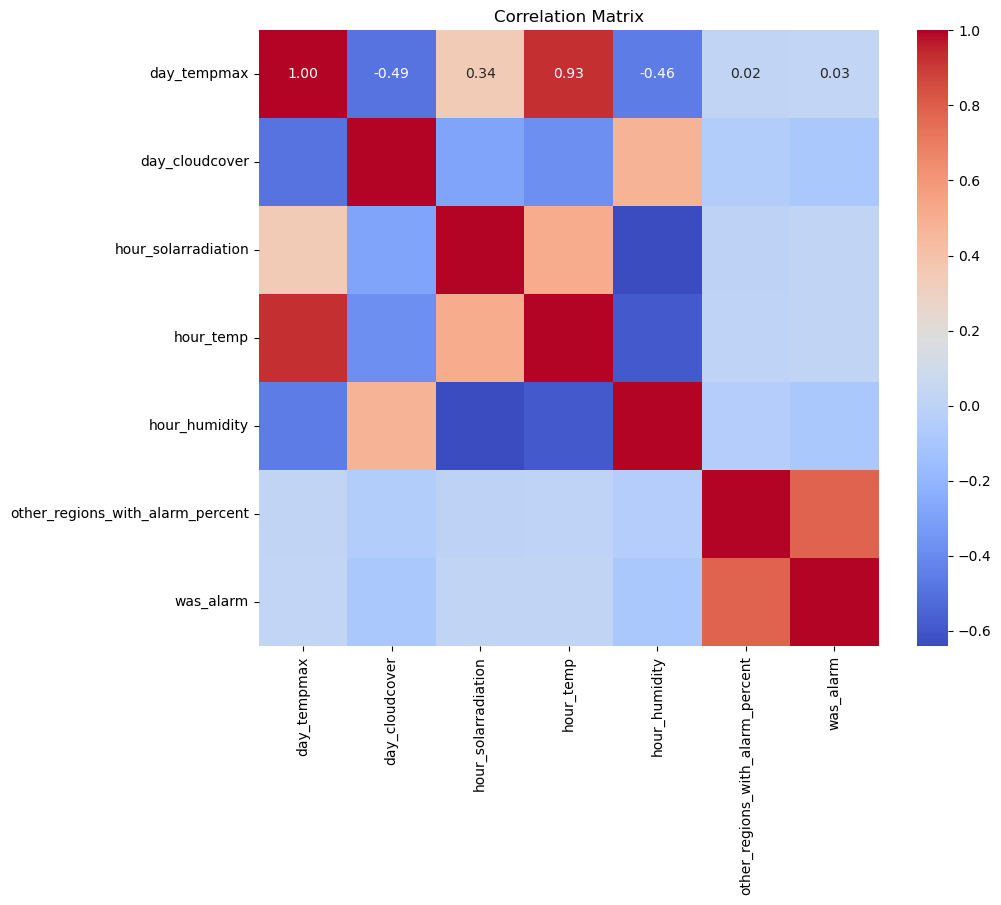

In [90]:
selected_features = [
    'day_tempmax', 'day_cloudcover', 'hour_solarradiation',
    'hour_temp', 'hour_humidity', 'other_regions_with_alarm_percent', 'was_alarm'
]

plt.figure(figsize=(10, 8))
sns.heatmap(merged_df[selected_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Visibility (hour_visibility) vs alarms

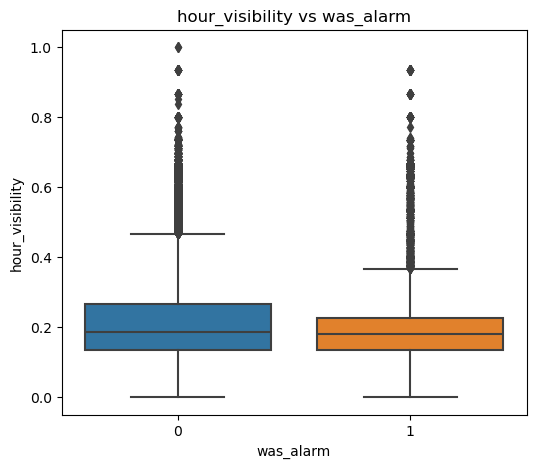

In [92]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=merged_df, x='was_alarm', y='hour_visibility')
plt.title('hour_visibility vs was_alarm')
plt.show()

## Cloud cover (hour_cloudcover) vs alarm

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


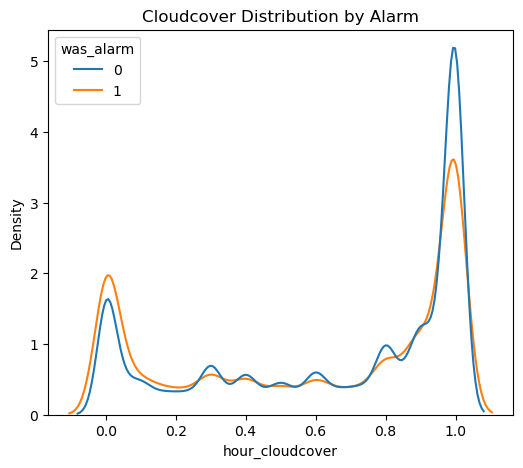

In [93]:
plt.figure(figsize=(6, 5))
sns.kdeplot(data=merged_df, x='hour_cloudcover', hue='was_alarm', common_norm=False)
plt.title('Cloudcover Distribution by Alarm')
plt.show()

## Wind (gusts) hour_windgust vs alarm

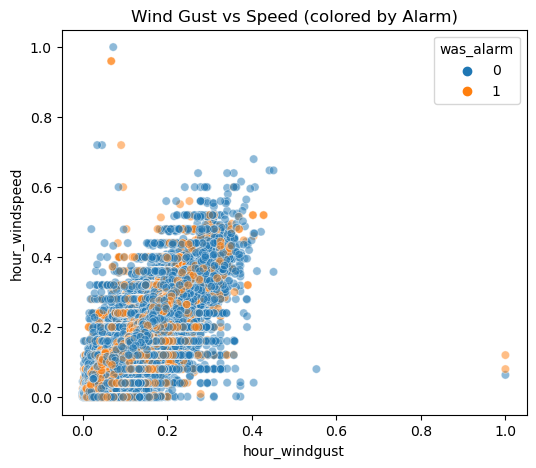

In [94]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=merged_df, x='hour_windgust', y='hour_windspeed', hue='was_alarm', alpha=0.5)
plt.title('Wind Gust vs Speed (colored by Alarm)')
plt.show()

In [ ]:
merged_df

## Daytime visibility (day_visibility) vs alarm

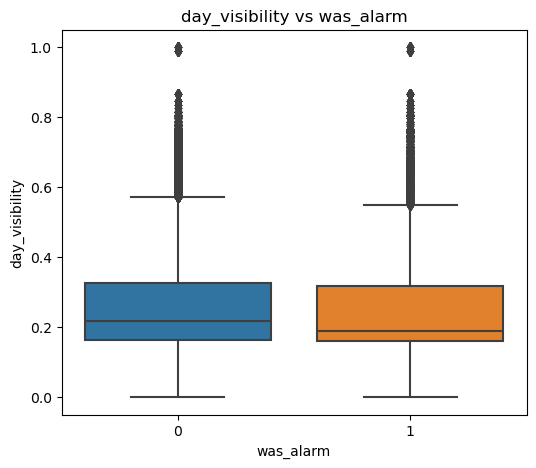

In [98]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=merged_df, x='was_alarm', y='day_visibility')
plt.title('day_visibility vs was_alarm')
plt.show()

## Effect of wind direction (hour_winddir)

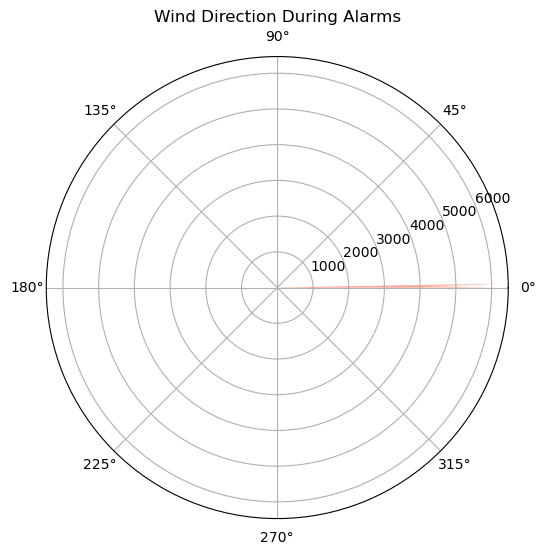

In [99]:
plt.figure(figsize=(6, 6))
wind_df = merged_df[merged_df['was_alarm'] == 1]  
wind_rad = np.deg2rad(wind_df['hour_winddir'])

plt.subplot(111, polar=True)
plt.hist(wind_rad, bins=36, color='tomato', alpha=0.7)
plt.title('Wind Direction During Alarms')
plt.show()

## Heatmap of correlations between all features and was_alarm

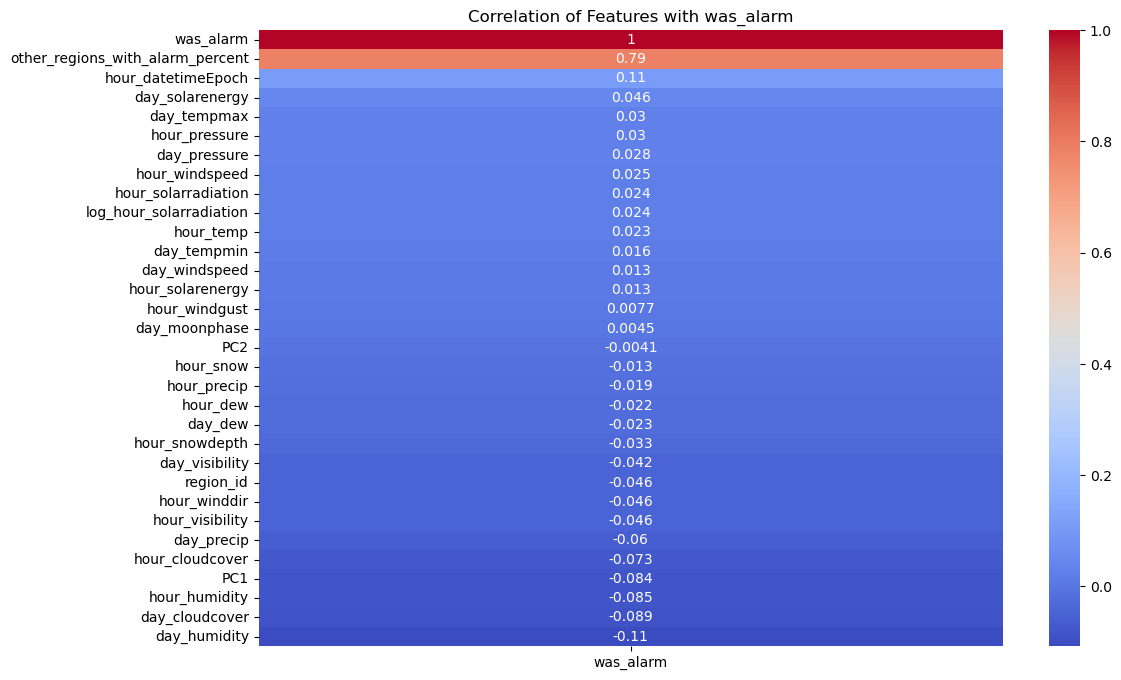

In [101]:
plt.figure(figsize=(12, 8))
cor = merged_df.corr(numeric_only=True)
sns.heatmap(cor[['was_alarm']].sort_values(by='was_alarm', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with was_alarm')
plt.show()
